# Tic-tac-toe RL

In [1]:
import gym
import numpy as np
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict 
from tqdm.notebook import tqdm
from torch.autograd import Variable

Второе домашнее задание опять посвящено игре; его базовая часть, надеюсь, не слишком большая, но я добавил опциональную часть, которая, думаю, должна быть достаточно интересной для любого слушателя. Как обычно, в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.

## Часть первая: крестики-нолики при помощи Q-обучения

В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.

In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [3]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1
        return self.getHash()

In [4]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s, a]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
#             else:
#                 ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if (s, (0, 0)) in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s, a])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, actions)

In [5]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        actions = [tuple(a) for a in actions]
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

In [6]:
class QLearning:
    """
    Q-learning for tic-tac-toe.
    """
    def __init__(self, env, alpha, epsilon, action_space = None, seed = None):
        """
            env          - blackjack environment with a step method (action -> (state, reward, done, _))
            alpha        - float, step size
            epsilon      - exploration rate
            action_space - list of available actions
            seed         - random seed
        """
        self.env = env
        self.alpha = alpha
        self.epsilon = epsilon
        self.action_space = (action_space or 
                               list((i, j) for i in range(self.env.n_rows) for j in range(self.env.n_cols)))
        self.Q = defaultdict(lambda: 0)
        np.random.seed(seed)
        env.seed(seed)
    
    def __choose_greedy_action(self, state):
        best_action = self.action_space[0]
        best_Q = self.Q[(state, best_action)]
        for action in self.action_space[1:]:
            current_Q = self.Q[(state, action)]
            if current_Q > best_Q:
                best_Q = current_Q
                best_action = action
        return best_action, best_Q
    
    def __choose_epsilon_greedy_action(self, state):
        if np.random.random() < self.epsilon:
            return self.action_space[np.random.randint(0, len(self.action_space))]
        else:
            return self.__choose_greedy_action(state)[0]
        
    def make_greedy_policy(self):
        return lambda state : self.__choose_greedy_action(state)[0]
    
    def getActionGreedy(self, s, actions):
        best_Q = self.Q[(s, actions[0])]
        best_i = 0
        for i, action in enumerate(actions):
            current_Q = self.Q[(s, action)]
            if current_Q > best_Q:
                best_Q = current_Q
                best_i = i
        return best_i
    
    def evaluate(self, n_trials):
        """
            Run Q-learning for n_trials episodes.
            Input:  n_trials - number of episodes
            Output: policy   - action determining function (state -> action)
        """
        for _ in range(n_trials):
            state_cross = self.env.reset()
            state_nought = None
            action_nought = None
            done = False
            while not done:
                # crosses make step
                action_cross = self.__choose_epsilon_greedy_action(state_cross)
                new_state_nought, reward, done, _ = self.env.step(action_cross)
                new_state_nought = new_state_nought[0]
                if (state_nought and action_nought) is not None:
                    # if noughts did any actions before, update their Q. Reward is negated for noughts
                    if (reward != -10):
                        self.Q[(state_nought, action_nought)] += (self.alpha * (-reward
                            + self.__choose_greedy_action(new_state_nought)[1]
                            - self.Q[(state_nought, action_nought)]))
                if done:
                    # if crosses end the game, update their Q
                    self.Q[(state_cross, action_cross)] += (self.alpha * (reward
                        - self.Q[(state_cross, action_cross)]))
                else:
                    # if game is not finished, noughts make a step. 
                    state_nought = new_state_nought
                    action_nought = self.__choose_epsilon_greedy_action(state_nought)
                    new_state_cross, reward, done, _ = self.env.step(action_nought)
                    new_state_cross = new_state_cross[0]
                    # update cross Q
                    if (reward != -10):
                        self.Q[(state_cross, action_cross)] += (self.alpha * (reward
                            + self.__choose_greedy_action(new_state_cross)[1]
                            - self.Q[(state_cross, action_cross)]))
                    if done:
                        # if noughts end the game, update their Q. Reward is negated for noughts
                        if (reward == -10):
                            reward *= -1
                        self.Q[(state_nought, action_nought)] += (self.alpha * (-reward
                            - self.Q[(state_nought, action_nought)]))
                    state_cross = new_state_cross
        return self.make_greedy_policy()

In [7]:
def evaluate_qlearning(policy, env, n_trials):
    average_results = []
    for player in ['crosses', 'noughts']:
        res = 0
        for _ in range(n_trials):
            state_cross = env.reset()
            done = False
            while not done:
                action_space = env.getEmptySpaces()
                action_cross = (policy(state_cross) if player == 'crosses' 
                    else tuple(action_space[np.random.randint(0, len(action_space))]))
                state_nought, reward, done, _ = env.step(action_cross)
                state_nought = state_nought[0]
                if not done:
                    action_space = env.getEmptySpaces()
                    action_nought = (policy(state_nought) if player == 'noughts'
                        else tuple(action_space[np.random.randint(0, len(action_space))]))
                    state_cross, reward, done, _ = env.step(action_nought)
                    state_cross = state_cross[0]
            if player == 'noughts' and reward != -10:
                reward *= -1
            res += reward
        res /= n_trials
        average_results.append(res)
    return average_results

In [8]:
def train_qlearning(model, env, cycles, trials_per_cycle, evaluation_trials):
    train_trials = 0
    cross_results = []
    nought_results = []
    train_trials_list = []
    for _ in tqdm(range(cycles)):
        policy = model.evaluate(trials_per_cycle)
        train_trials += trials_per_cycle
        cross_result, nought_result = evaluate_qlearning(policy, env, evaluation_trials)
        cross_results.append(cross_result)
        nought_results.append(nought_result)
        train_trials_list.append(train_trials)
    plt.plot(train_trials_list, cross_results, label='Crosses average score')
    plt.plot(train_trials_list, nought_results, label='Noughts average score')
    plt.title('Q-learning training curve')
    plt.legend()
    return model

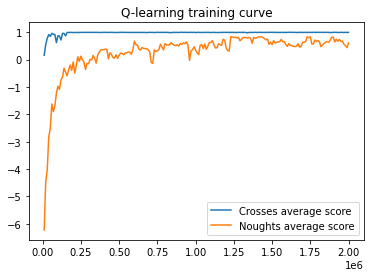

In [9]:
env = TicTacToe(3, 3, 3)
qlearning = QLearning(env, alpha=1e-2, epsilon=0.2, seed=2)
qlearning = train_qlearning(qlearning, env, 200, 10000, 1000)
qlearning3x3 = qlearning

In [10]:
cross_res, nought_res = evaluate_qlearning(qlearning.make_greedy_policy(), env, 10000)
print(f'Average cross result against random policy: {cross_res}')
print(f'Average nought result against random policy: {nought_res}')

Average cross result against random policy: 0.9954
Average nought result against random policy: 0.6186


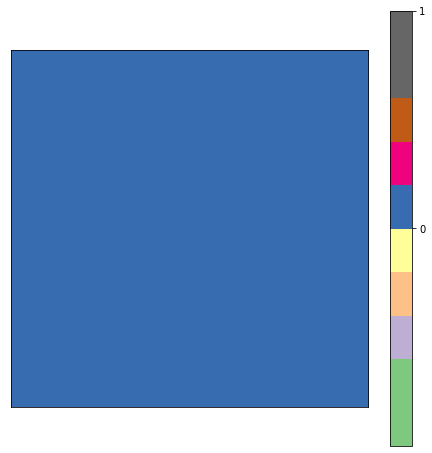

0 (0, 0) 0.33927539752789637
1 (0, 1) 0.2337340311041221
2 (0, 2) 0.2182525483878406
3 (1, 0) 0.18850759856448393
4 (1, 1) 0.19959784550639406
5 (1, 2) 0.10149760970199179
6 (2, 0) 0.19543945911160424
7 (2, 1) 0.06550562022011351
8 (2, 2) 0.14095156706584047


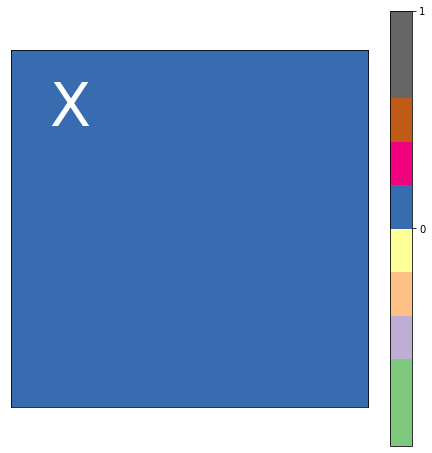

0 (0, 1) -0.6588504791549924
1 (0, 2) -0.6214405209130566
2 (1, 0) -0.73187969970555
3 (1, 1) 0.1262430774789118
4 (1, 2) -0.7172541334634815
5 (2, 0) -0.5779219382497485
6 (2, 1) -0.5917601119200674
7 (2, 2) -0.6848382854336859


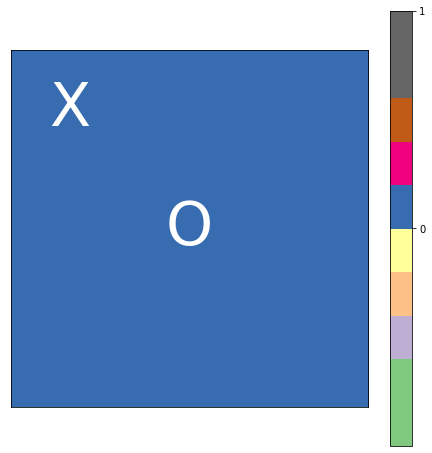

0 (0, 1) 0.139918651176756
1 (0, 2) 0.11373912867565156
2 (1, 0) 0.19960680402318295
3 (1, 2) 0.12793784271017886
4 (2, 0) 0.10574499973796603
5 (2, 1) 0.08603560940273221
6 (2, 2) 0.10563581509510325


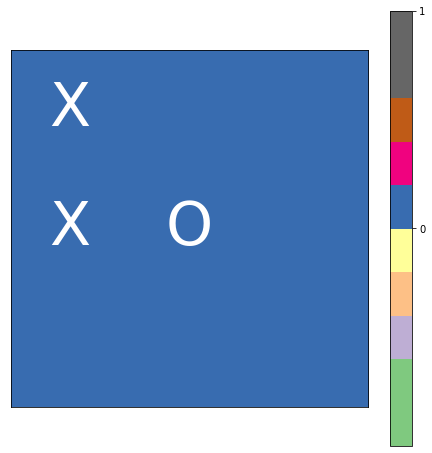

0 (0, 1) -0.7669050415562887
1 (0, 2) -0.7689205759371633
2 (1, 2) -0.8239453991920108
3 (2, 0) 0.11690283824392333
4 (2, 1) -0.8879035338196467
5 (2, 2) -0.9273515660885663


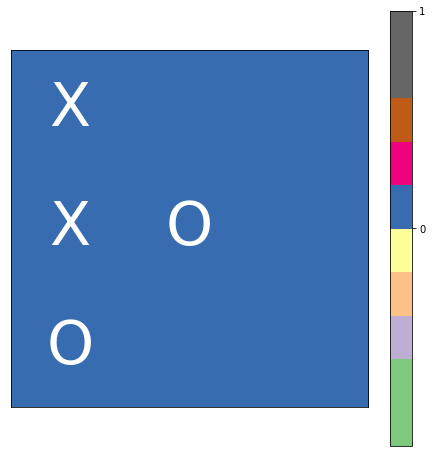

0 (0, 1) -0.9138463666288096
1 (0, 2) 0.058847535931652546
2 (1, 2) -0.9557780790481544
3 (2, 1) -0.8874224361155147
4 (2, 2) -0.9618133867224473


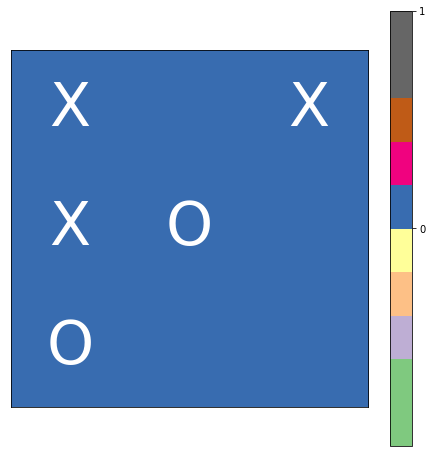

0 (0, 1) 0.05029384335699853
1 (1, 2) -0.9575029603040002
2 (2, 1) -0.8552129978810477
3 (2, 2) -0.9277431969180868


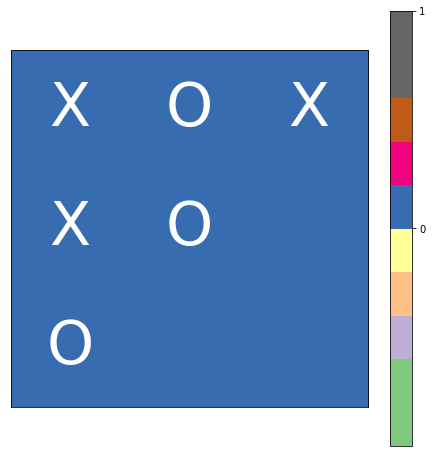

0 (1, 2) -0.9723794017353508
1 (2, 1) 0.0
2 (2, 2) -0.9684384426010729


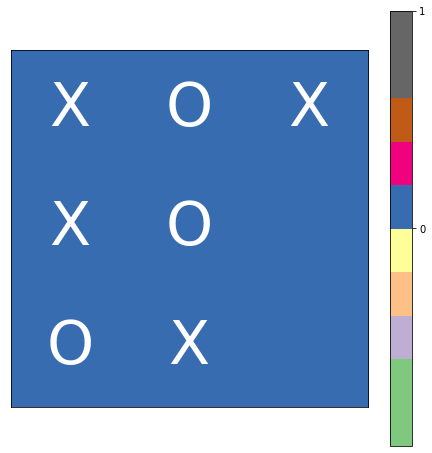

0 (1, 2) 0.0
1 (2, 2) 0.0


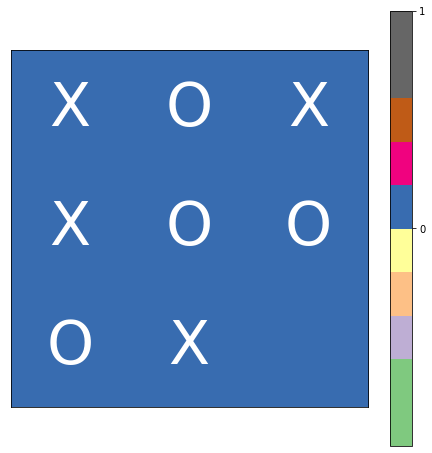

0 (2, 2) 0.0


In [11]:
plot_test_game(env, qlearning, qlearning, random_naughts=False)

2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

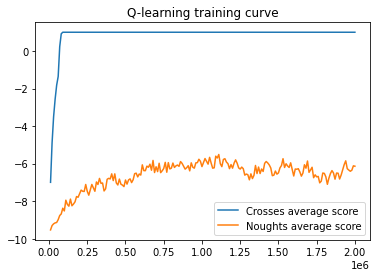

In [12]:
env = TicTacToe(4, 4, 3)
qlearning = QLearning(env, alpha=1e-2, epsilon=0.15, seed=2)
qlearning = train_qlearning(qlearning, env, 200, 10000, 1000)

In [13]:
cross_res, nought_res = evaluate_qlearning(qlearning.make_greedy_policy(), env, 10000)
print(f'Average cross result against random policy: {cross_res}')
print(f'Average nought result against random policy: {nought_res}')

Average cross result against random policy: 1.0
Average nought result against random policy: -6.2569


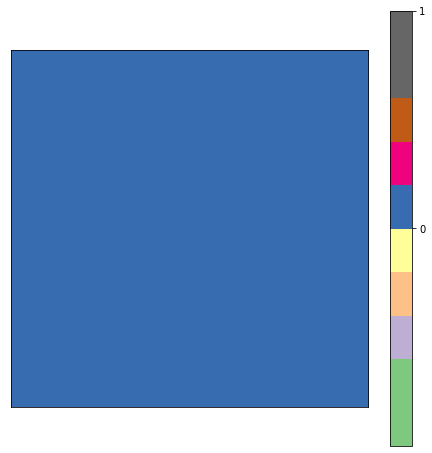

0 (0, 0) 0.9984413776636786
1 (0, 1) 0.45427382187235393
2 (0, 2) 0.0435229396438247
3 (0, 3) 0.0024106671607115404
4 (1, 0) 0.0276317965566372
5 (1, 1) 0.006756336595465435
6 (1, 2) 0.004450231933414051
7 (1, 3) 0.0014621878470678262
8 (2, 0) 0.005668433448009899
9 (2, 1) 0.0008796664429137952
10 (2, 2) 0.09738152775108712
11 (2, 3) 0.0062001844104948274
12 (3, 0) 0.002120903906952751
13 (3, 1) 0.002626150802534093
14 (3, 2) 0.004490814048784601
15 (3, 3) 0.0011216048126730378


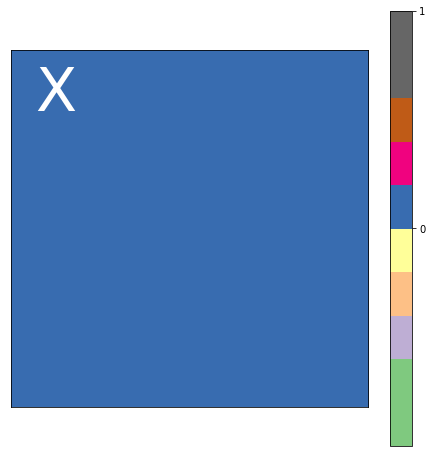

0 (0, 1) -0.644071752883901
1 (0, 2) -0.6926675745890852
2 (0, 3) -0.6629379202831899
3 (1, 0) -0.6496854831932646
4 (1, 1) -0.2503653102237114
5 (1, 2) -0.5881067488758142
6 (1, 3) -0.6550167825850012
7 (2, 0) -0.7107548122910795
8 (2, 1) -0.6469909731441356
9 (2, 2) -0.5445033529230296
10 (2, 3) -0.6474592639061146
11 (3, 0) -0.633444763438625
12 (3, 1) -0.6667900147104336
13 (3, 2) -0.5886850801528978
14 (3, 3) -0.5910730992594934


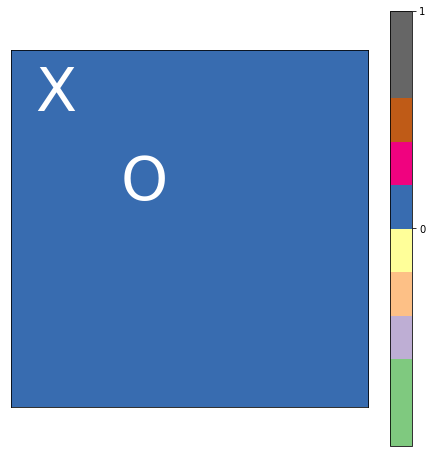

0 (0, 1) 0.9999862807263145
1 (0, 2) -0.6152416430216539
2 (0, 3) -0.6879290408061818
3 (1, 0) 0.6414318012099284
4 (1, 2) -0.7756113652550303
5 (1, 3) -0.548458652149989
6 (2, 0) -0.6966124495532564
7 (2, 1) -0.7716199697563164
8 (2, 2) -0.7449487824532285
9 (2, 3) -0.7077369074717166
10 (3, 0) -0.4882475915971316
11 (3, 1) -0.6258858575334034
12 (3, 2) -0.4168024208547292
13 (3, 3) -0.6152396125488598


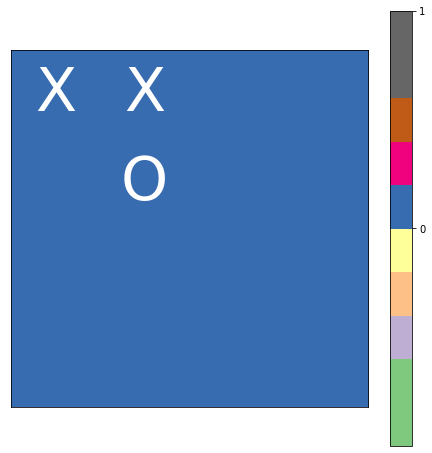

0 (0, 2) -0.4430011383485125
1 (0, 3) -0.9185901443097391
2 (1, 0) -0.8261507257381037
3 (1, 2) -0.8493260665966166
4 (1, 3) -0.8874116312551168
5 (2, 0) -0.8773545316467354
6 (2, 1) -0.8317930377291116
7 (2, 2) -0.7792777778205059
8 (2, 3) -0.8777088696509984
9 (3, 0) -0.9111890553792605
10 (3, 1) -0.8694252686201507
11 (3, 2) -0.9127056076833981
12 (3, 3) -0.9266725913918044


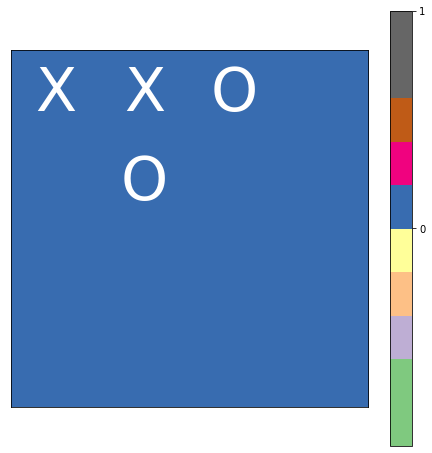

0 (0, 3) -0.9280538874652305
1 (1, 0) -0.7817996418904819
2 (1, 2) -0.8406723973675541
3 (1, 3) -0.9113300658055195
4 (2, 0) 0.9999798703243739
5 (2, 1) -0.9376199940664975
6 (2, 2) -0.9017864629259993
7 (2, 3) -0.8408263649271006
8 (3, 0) -0.912219307980657
9 (3, 1) -0.9142648095912423
10 (3, 2) -0.8685296155578812
11 (3, 3) -0.9404966291958965


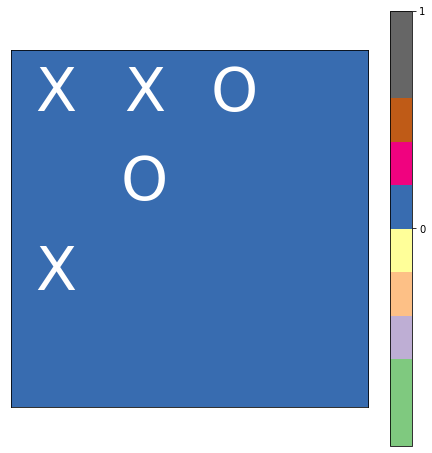

0 (0, 3) -0.9221581396713966
1 (1, 0) -0.657159419564295
2 (1, 2) -0.8417162829767623
3 (1, 3) -0.8706782816058476
4 (2, 1) -0.8894126326886268
5 (2, 2) -0.8600976717011873
6 (2, 3) -0.8916377003311162
7 (3, 0) -0.8341934587536157
8 (3, 1) -0.9069873066593673
9 (3, 2) -0.9418231037465251
10 (3, 3) -0.8816014981922042


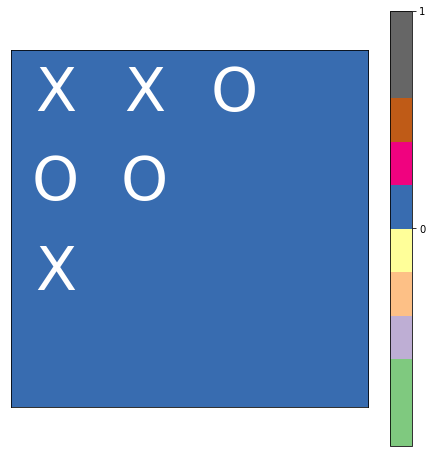

0 (0, 3) -0.8590710701694039
1 (1, 2) 0.9999999999999889
2 (1, 3) -0.8942985621589048
3 (2, 1) -0.8908734705549108
4 (2, 2) -0.8860535804897145
5 (2, 3) -0.8595468740228018
6 (3, 0) -0.9339223257603896
7 (3, 1) -0.9218609477602252
8 (3, 2) -0.9201454295449378
9 (3, 3) -0.963354853492596


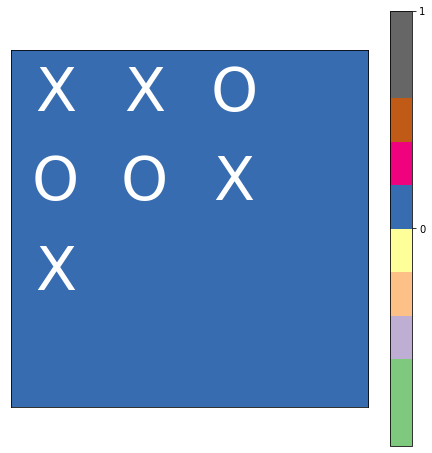

0 (0, 3) -0.936497807342004
1 (1, 3) -0.9486633451726347
2 (2, 1) -0.9441888254481582
3 (2, 2) -0.9198999443367853
4 (2, 3) -0.8398076584711438
5 (3, 0) -0.929356358326828
6 (3, 1) -0.9331645299577804
7 (3, 2) -0.9306879714825138
8 (3, 3) -0.9357633662908926


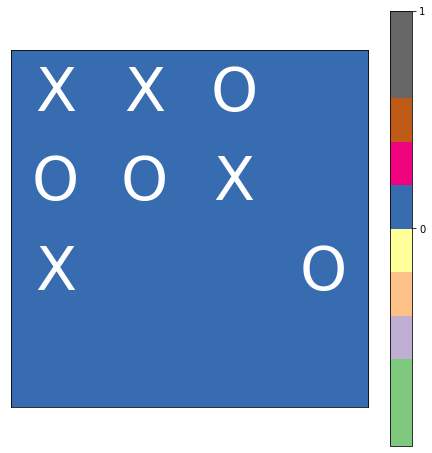

0 (0, 3) -0.8580186344309213
1 (1, 3) -0.8827962558739757
2 (2, 1) 0.9999999999999889
3 (2, 2) 0.9984824307324003
4 (3, 0) -0.8586117629378481
5 (3, 1) -0.830009614714878
6 (3, 2) -0.8519093470736777
7 (3, 3) -0.856022155370717


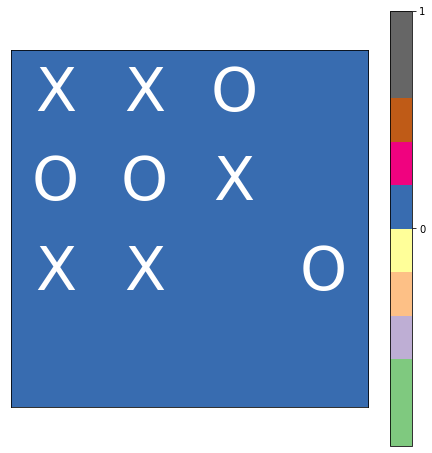

0 (0, 3) -0.9742245444278179
1 (1, 3) -0.9745674359503328
2 (2, 2) -0.9327580653479776
3 (3, 0) -0.9872428113109665
4 (3, 1) -0.9874772066131915
5 (3, 2) -0.9877282759765377
6 (3, 3) -0.9752813354913381


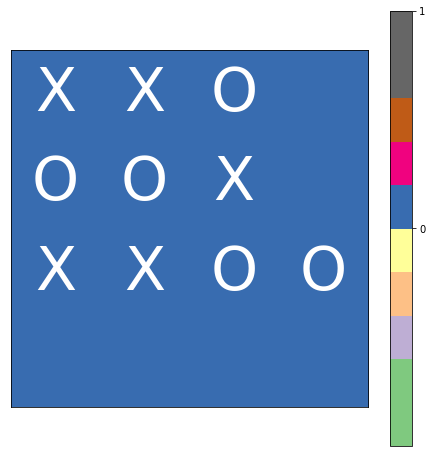

0 (0, 3) 0.9999999999999944
1 (1, 3) -0.4880230765326353
2 (3, 0) 0.595268027321676
3 (3, 1) -0.48331904801179526
4 (3, 2) -0.5433902522560852
5 (3, 3) 0.0036508465438455707
Крестики выиграли!


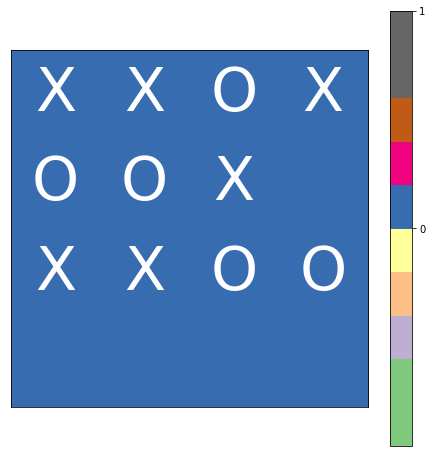

In [14]:
plot_test_game(env, qlearning, qlearning, random_naughts=False)

## Часть вторая: добавим нейронных сетей

Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).

3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

In [15]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [16]:
class TicTacToeDQN():
    def __init__(self, env, model_class,
                 memory_size = 10000,
                 gamma=1, batch_size=64, lr=0.001,
                 eps_init=0.9, eps_final=0.05, eps_decay=200):
        self.env = env
        self.model_crosses = model_class()
        self.model_noughts = model_class()
        self.memory_crosses = ReplayMemory(memory_size)
        self.memory_noughts = ReplayMemory(memory_size)
        self.optimizer_crosses = optim.Adam(self.model_crosses.parameters(), lr)
        self.optimizer_noughts = optim.Adam(self.model_noughts.parameters(), lr)
        
        self.gamma = 1
        self.batch_size = batch_size
        
        self.eps_init, self.eps_final, self.eps_decay = eps_init, eps_final, eps_decay
        self.num_step = 0
        
        self.action_space = list((i, j) for i in range(self.env.n_rows) for j in range(self.env.n_cols))
        
    def tensor_from_hash(self, board_hash):
        '''
        Returns tensor representing a board of shape (3, n_rows, n_cols)
        '''
        board_hash = np.array([int(digit) for digit in board_hash])
        res = np.zeros((3, self.env.n_rows*self.env.n_cols))
        res[board_hash, np.arange(len(board_hash))] = 1
        res = res.reshape(3, self.env.n_rows, self.env.n_cols)
        return torch.unsqueeze(torch.Tensor(res).to(torch.float32), 0)
        
    def select_greedy_action(self, state, model):
        return model(state).data.max(1)[1].view(1, 1)
    
    def select_action(self, state, model):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state, model)
        else:
            action_space = self.env.getEmptySpaces()
            action = action_space[np.random.randint(0, len(action_space))]
            return torch.tensor([[self.env.n_cols * action[0] + action[1]]], dtype=torch.int64)
        
    def run_episode_for_model(self, model, initial_state, memory, greedy=False, noughts=False):
        state = self.tensor_from_hash(initial_state)
        done = False
        while not done:
            with torch.no_grad():
                if greedy:
                    action = self.select_greedy_action(state, model)
                else:
                    action = self.select_action(state, model)
            (next_state, empty_spaces, _), reward, done, _ = self.env.step(self.action_space[action.numpy()[0][0]])
            if noughts and int(abs(reward)) == 1:
                reward *= -1
            if done:
                next_state = self.tensor_from_hash(next_state)
                transition = (state, action, next_state, torch.tensor([reward], dtype=torch.float32))
                memory.store(transition)
                break
            enemy_action = tuple(empty_spaces[np.random.randint(0, len(empty_spaces))])
            (next_state, _, _), reward, done, _ = self.env.step(enemy_action)
            next_state = self.tensor_from_hash(next_state)
            if noughts and int(abs(reward)) == 1:
                reward *= -1
            transition = (state, action, next_state, torch.tensor([reward], dtype=torch.float32))
            memory.store(transition)
            state = next_state
            
    def run_episode(self, do_learning=True, greedy=False):
        cross_state = self.env.reset()
        self.run_episode_for_model(self.model_crosses, cross_state, self.memory_crosses, greedy=greedy)
        cross_state = self.env.reset()
        cross_action = tuple(self.action_space[np.random.randint(0, len(self.action_space))])
        nought_state = self.env.step(cross_action)[0][0]
        self.run_episode_for_model(self.model_noughts, nought_state, self.memory_noughts, greedy=greedy, noughts=True)
        if do_learning:
            self.learn()
                
    def learn_one_batch(self, model, memory, optimizer):
        if len(memory) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))

        # считаем значения функции Q
        Q = model(batch_state).gather(1, batch_action).reshape([self.batch_size])

        # оцениваем ожидаемые значения после этого действия
        Qmax = model(batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)

        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    def learn(self):
        self.learn_one_batch(self.model_crosses, self.memory_crosses, self.optimizer_crosses)
        self.learn_one_batch(self.model_noughts, self.memory_noughts, self.optimizer_noughts)

In [17]:
class Network3x3(nn.Module):
    def __init__(self, num_channels=120):
        nn.Module.__init__(self)
        self.conv = nn.Conv2d(3, num_channels*2, 3)
        self.l1 = nn.Linear(num_channels*2, num_channels)
        self.l2 = nn.Linear(num_channels, 9)
    
    def forward(self, x):
        """
        Input: tensor batch_size x C x W x H
        Output: tensor batch_size x 9
        """
        x = F.relu(self.conv(x))
        x = F.relu(self.l1(torch.flatten(x, start_dim=1)))
        x = self.l2(x)
        return x

In [18]:
def evaluate_dqn(dqn, n_trials):
    def policy(state, crosses=True):
        state = dqn.tensor_from_hash(state)
        if crosses:
            model = dqn.model_crosses
        else:
            model = dqn.model_noughts
        with torch.no_grad():
            action = dqn.action_space[dqn.select_greedy_action(state, model).numpy()[0][0]]
        return action
        
    average_results = []
    for player in ['crosses', 'noughts']:
        env = dqn.env
        res = 0
        for _ in range(n_trials):
            state_cross = env.reset()
            done = False
            while not done:
                action_space = env.getEmptySpaces()
                action_cross = (policy(state_cross, crosses=True) if player == 'crosses' 
                    else tuple(action_space[np.random.randint(0, len(action_space))]))
                state_nought, reward, done, _ = env.step(action_cross)
                state_nought = state_nought[0]
                if not done:
                    action_space = env.getEmptySpaces()
                    action_nought = (policy(state_nought, crosses=False) if player == 'noughts'
                        else tuple(action_space[np.random.randint(0, len(action_space))]))
                    state_cross, reward, done, _ = env.step(action_nought)
                    state_cross = state_cross[0]
            if player == 'noughts' and reward != -10:
                reward *= -1
            res += reward
        res /= n_trials
        average_results.append(res)
    return average_results

In [19]:
def train_dqn(model, cycles, trials_per_cycle, evaluation_trials):
    train_trials = 0
    cross_results = []
    nought_results = []
    train_trials_list = []
    for _ in tqdm(range(cycles)):
        for _ in range(trials_per_cycle):
            dqn.run_episode(do_learning=False)
        for _ in range(int(trials_per_cycle/10)):
            dqn.learn()
        train_trials += trials_per_cycle
        cross_result, nought_result = evaluate_dqn(dqn, evaluation_trials)
        cross_results.append(cross_result)
        nought_results.append(nought_result)
        train_trials_list.append(train_trials)
    plt.plot(train_trials_list, cross_results, label='Crosses average score')
    plt.plot(train_trials_list, nought_results, label='Noughts average score')
    plt.title('DQN training curve')
    plt.legend()
    print(f'Crosses average score: {cross_results[-1]}.')
    print(f'Noughts average score: {nought_results[-1]}.')
    return model


Crosses average score: 0.543.
Noughts average score: -3.174.


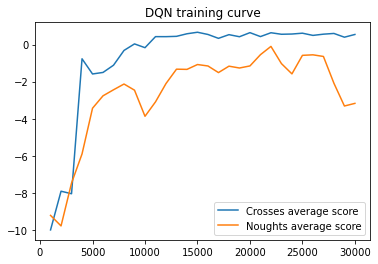

In [20]:
env = TicTacToe()
dqn = TicTacToeDQN(env, Network3x3, eps_init=0.99, eps_decay=50000, gamma=0.8, batch_size=256, lr=3e-5, memory_size=50000)
dqn = train_dqn(dqn, cycles=30, trials_per_cycle=1000, evaluation_trials=1000)

4. Реализуйте Double DQN и/или Dueling DQN.

In [21]:
class Network3x3Dueling(nn.Module):
    def __init__(self, num_channels=120):
        nn.Module.__init__(self)
        self.conv = nn.Conv2d(3, num_channels*2, 3)
        self.l1 = nn.Linear(num_channels*2, num_channels)
        self.action_head = nn.Linear(num_channels, 9)
        self.state_head = nn.Linear(num_channels, 1)
    
    def forward(self, x):
        """
        Input: tensor batch_size x C x W x H
        Output: tensor batch_size x 9
        """
        x = F.relu(self.conv(x)) # BS x 2C' x 1 x 1
        x = F.relu(self.l1(torch.flatten(x, start_dim=1))) # BS x C'
        state_value = self.state_head(x) # BS x 1
        action_values = self.action_head(x) # BS x 9
        x = state_value + action_values - torch.mean(action_values, 1, True) # BS x 9
        return x


Crosses average score: 0.796.
Noughts average score: -1.256.


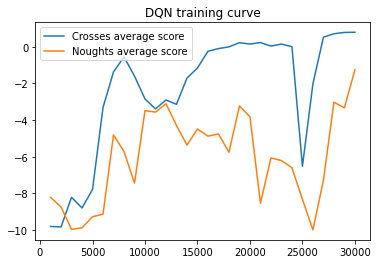

In [22]:
env = TicTacToe()
dqn = TicTacToeDQN(env, Network3x3Dueling, eps_init=0.99, eps_decay=50000, gamma=0.8, batch_size=256, lr=3e-5, memory_size=50000)
dqn = train_dqn(dqn, cycles=30, trials_per_cycle=1000, evaluation_trials=1000)

# Часть третья: расширим и углубим поиск

Крестики-нолики -- это, конечно, далеко не го, и обычный альфа-бета поиск с отсечением здесь наверняка может работать идеально вплоть до довольно больших досок. Однако мы всё-таки для этого учебного задания будем реализовывать более практически релевантный метод MCTS -- заодно фактически получится и упражнение на многоруких бандитов.